24 H - ECG ANALYSIS

In [16]:
import scipy.io

# 1. Path to your .mat file
MAT_PATH = r'C:\Users\prith\Desktop\COMPLEX DATA ANALYSIS IN PHYSIOLOGY\projects\24h-ecg-analysis\ecg_data\19070921.mat'

# 2. Load the file
mat = scipy.io.loadmat(MAT_PATH)

# 3. Inspect available variables
print("Variables in .mat file:", [k for k in mat.keys() if not k.startswith('__')])


Variables in .mat file: ['all', 'sleep', 'day']


In [17]:
import numpy as np

# 1. Extract and flatten
ecg_day   = mat['day'].ravel()
ecg_sleep = mat['sleep'].ravel()
ecg_all   = mat['all'].ravel()

# 2. Print out the lengths
print(f"ecg_day   → {ecg_day.shape[0]} samples")
print(f"ecg_sleep → {ecg_sleep.shape[0]} samples")
print(f"ecg_all   → {ecg_all.shape[0]} samples")


ecg_day   → 15108096 samples
ecg_sleep → 6600000 samples
ecg_all   → 21708096 samples


In [18]:
from scipy.signal import resample_poly

# 1) Original and target sampling rates
fs_orig   = 250   # Hz
fs_target = 100   # Hz

# 2) Compute up/down factors for resample_poly
up = fs_target
down = fs_orig

# 3) Down‑sample with polyphase filtering
ecg_day_ds   = resample_poly(ecg_day,   up, down)
ecg_sleep_ds = resample_poly(ecg_sleep, up, down)

# 4) Check new lengths and durations
print(f"Day down‑sampled → {ecg_day_ds.shape[0]} samples ({ecg_day_ds.shape[0]/fs_target:.1f} s)")
print(f"Sleep down‑sampled → {ecg_sleep_ds.shape[0]} samples ({ecg_sleep_ds.shape[0]/fs_target:.1f} s)")


Day down‑sampled → 6043239 samples (60432.4 s)
Sleep down‑sampled → 2640000 samples (26400.0 s)


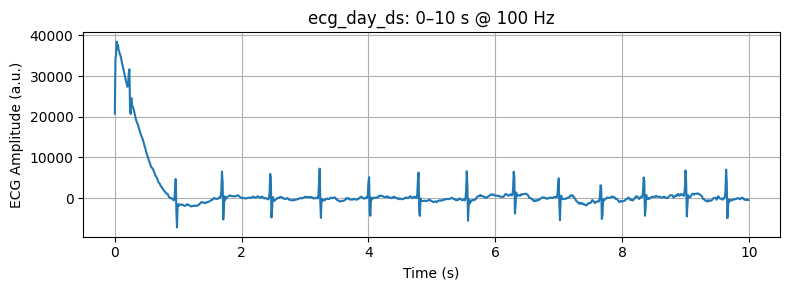

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# ---- PARAMETERS ----
fs = fs_target           # sampling rate after down‑sampling (100 Hz)
start_sec = 0            # start time in seconds
duration_sec = 10        # duration of segment to plot (in seconds)

# ---- EXTRACT SEGMENT ----
start_idx = int(start_sec * fs)
end_idx   = start_idx + int(duration_sec * fs)
segment   = ecg_day_ds[start_idx:end_idx]
t         = np.arange(start_idx, end_idx) / fs  # time vector in seconds

# ---- PLOTTING ----
plt.figure(figsize=(8, 3))
plt.plot(t, segment)
plt.xlabel('Time (s)')
plt.ylabel('ECG Amplitude (a.u.)')
plt.title(f'ecg_day_ds: {start_sec}–{start_sec+duration_sec} s @ {fs} Hz')
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
import neurokit2 as nk

# 1) Detect R‑peaks in the daytime segment
_, info_day = nk.ecg_peaks(ecg_day_ds, sampling_rate=fs_target)
rpeaks_day = info_day["ECG_R_Peaks"]
print(f"Day:   Detected {len(rpeaks_day)} R‑peaks")

# 2) Detect R‑peaks in the nighttime segment
_, info_sleep = nk.ecg_peaks(ecg_sleep_ds, sampling_rate=fs_target)
rpeaks_sleep = info_sleep["ECG_R_Peaks"]
print(f"Sleep: Detected {len(rpeaks_sleep)} R‑peaks")

# (Optional) Convert indices to times in seconds:
times_day   = rpeaks_day   / fs_target
times_sleep = rpeaks_sleep / fs_target

# Now `rpeaks_day` and `rpeaks_sleep` are your sample indices,
# and `times_day`/`times_sleep` give you the occurrence times.


Day:   Detected 78351 R‑peaks
Sleep: Detected 25683 R‑peaks


In [21]:
import numpy as np
import neurokit2 as nk
from scipy.signal import butter, filtfilt, iirnotch

# --- PARAMETERS ---
fs = fs_target            # e.g. 100 Hz
lowcut, highcut = 0.5, 40 # Hz
notch_freq = 50.0         # Hz
Q = 30                    # notch filter Q
rr_min, rr_max = 300, 2000  # ms

# --- FILTER DESIGN ---
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    return butter(order, [lowcut/nyq, highcut/nyq], btype='band')

def apply_filters(x):
    b_bp, a_bp = butter_bandpass(lowcut, highcut, fs)
    x_bp = filtfilt(b_bp, a_bp, x)
    w0 = notch_freq / (0.5 * fs)
    b_notch, a_notch = iirnotch(w0, Q)
    return filtfilt(b_notch, a_notch, x_bp)

# --- 1) FILTER ONCE & STORE ---
ecg_day_clean   = apply_filters(ecg_day_ds)
ecg_sleep_clean = apply_filters(ecg_sleep_ds)

In [22]:
# --- 2) R‑PEAKS & HRV USING FILTERED SIGNALS ---
for label, ecg_clean in [("Day", ecg_day_clean), ("Night", ecg_sleep_clean)]:
    # a) Detect R‑peaks
    _, info   = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    rpeaks    = info["ECG_R_Peaks"]
    
    # b) RR-intervals & artifact rejection
    rr        = np.diff(rpeaks) / fs * 1000
    rr_clean  = rr[(rr > rr_min) & (rr < rr_max)]
    
    # c) HRV metrics
    sdnn  = np.std(rr_clean,    ddof=1)
    rmssd = np.sqrt(np.mean(np.diff(rr_clean)**2))
    
    # d) Print
    print(f"{label}: Beats={len(rpeaks)}, Valid RR={len(rr_clean)}, SDNN={sdnn:.1f} ms, RMSSD={rmssd:.1f} ms")

Day: Beats=78374, Valid RR=78345, SDNN=130.6 ms, RMSSD=61.3 ms
Night: Beats=25714, Valid RR=25708, SDNN=117.7 ms, RMSSD=74.7 ms


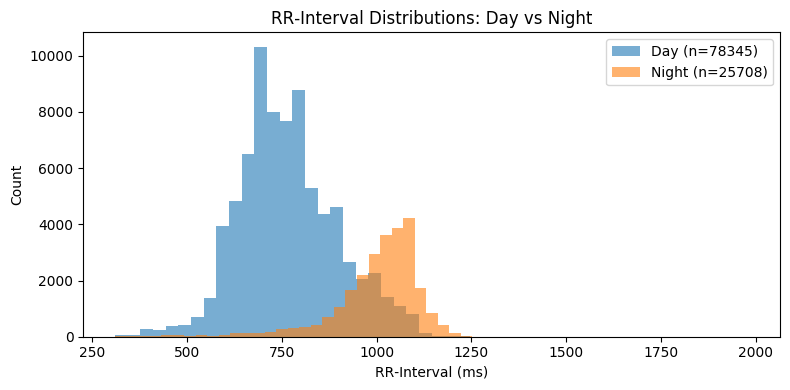

In [23]:
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt

# --- PARAMETERS (reuse originals) ---
fs = fs_target            # e.g. 100 Hz
rr_min, rr_max = 300, 2000  # ms thresholds

# --- ASSUMES YOU HAVE ecg_day_clean & ecg_sleep_clean IN SCOPE ---

# 1) Detect R‑peaks & compute RR-clean for Day
_, info_day   = nk.ecg_peaks(ecg_day_clean,   sampling_rate=fs)
rpeaks_day    = info_day["ECG_R_Peaks"]
rr_day        = np.diff(rpeaks_day) / fs * 1000
rr_day_clean  = rr_day[(rr_day > rr_min) & (rr_day < rr_max)]

# 2) Detect R‑peaks & compute RR-clean for Night
_, info_night = nk.ecg_peaks(ecg_sleep_clean, sampling_rate=fs)
rpeaks_night  = info_night["ECG_R_Peaks"]
rr_night      = np.diff(rpeaks_night) / fs * 1000
rr_night_clean= rr_night[(rr_night > rr_min) & (rr_night < rr_max)]

# 3) Plot histograms
plt.figure(figsize=(8,4))
plt.hist(rr_day_clean,   bins=50, alpha=0.6, label=f'Day (n={len(rr_day_clean)})')
plt.hist(rr_night_clean, bins=50, alpha=0.6, label=f'Night (n={len(rr_night_clean)})')
plt.xlabel('RR‑Interval (ms)')
plt.ylabel('Count')
plt.title('RR‑Interval Distributions: Day vs Night')
plt.legend()
plt.tight_layout()
plt.show()


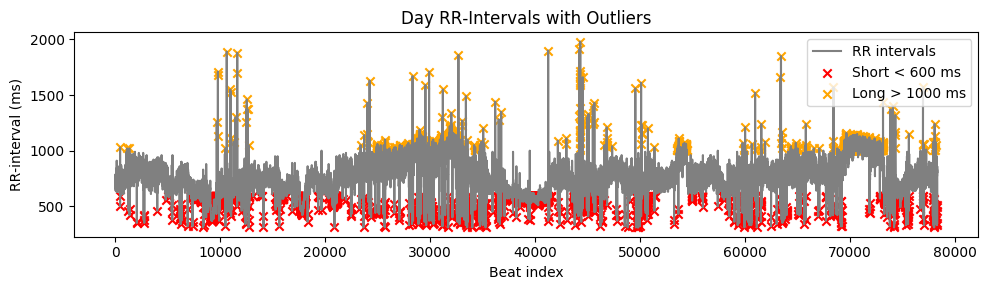

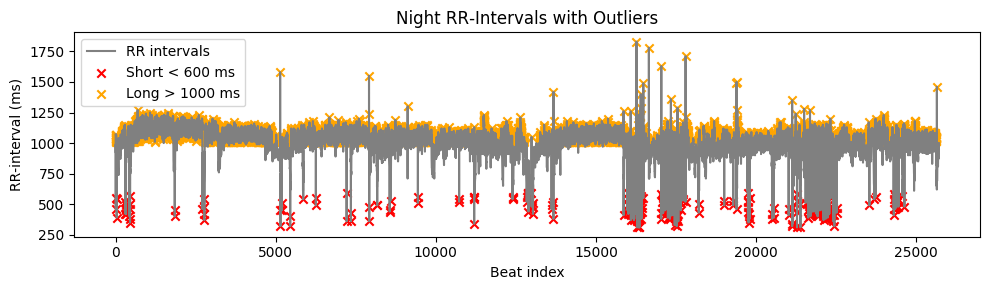

In [24]:
# Assume you already have np, plt, rr_day_clean, rr_night_clean,
# and short_thresh/long_thresh defined in your notebook.

for label, rr in [("Day", rr_day_clean), ("Night", rr_night_clean)]:
    idx       = np.arange(len(rr))
    out_short = np.where(rr < short_thresh)[0]
    out_long  = np.where(rr > long_thresh)[0]

    plt.figure(figsize=(10,3))
    # Plot RR series in a neutral gray
    plt.plot(idx, rr, '-', color='gray', label='RR intervals')
    # Short outliers in red
    plt.scatter(out_short, rr[out_short],
                color='red', marker='x', label=f'Short < {short_thresh} ms')
    # Long outliers in orange
    plt.scatter(out_long, rr[out_long],
                color='orange', marker='x', label=f'Long > {long_thresh} ms')

    plt.title(f"{label} RR‑Intervals with Outliers")
    plt.xlabel("Beat index")
    plt.ylabel("RR‑interval (ms)")
    plt.legend()
    plt.tight_layout()
    plt.show()
